This Notebook is for troubleshooting purposes

Check directory

In [1]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())

c:\Users\mehme\OneDrive\Desktop\All\Code\FreshStart


Import relavent modules and functions

In [2]:
import torch
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from  AdditionalFunctionsCode.HelpfulFunctions import *
from AdditionalFunctionsCode.SolverFunctions import *
from DataGenerationCode.DataGeneration import *
from SINDyCode.SINDyPreamble import *

Test Henkel Matrix

In [3]:

x = np.sin(np.linspace(0, 10, 100))  # Example time series
dimension = 10
delays = 90

H = get_hankel(x, dimension, delays)  # Returns a NumPy array
H_tensor = torch.tensor(H, dtype=torch.float32)  # Convert to PyTorch tensor

print("Hankel Matrix Shape:", H_tensor.shape)  # Expected: (dimension, delays)
print(H_tensor)  # Print a small portion to verify correctness

Hankel Matrix Shape: torch.Size([10, 90])
tensor([[ 0.0000,  0.1008,  0.2006,  0.2984,  0.3931,  0.4839,  0.5696,  0.6496,
          0.7230,  0.7889,  0.8469,  0.8962,  0.9364,  0.9670,  0.9878,  0.9985,
          0.9990,  0.9893,  0.9696,  0.9399,  0.9007,  0.8523,  0.7952,  0.7300,
          0.6574,  0.5781,  0.4928,  0.4026,  0.3082,  0.2107,  0.1111,  0.0103,
         -0.0906, -0.1906, -0.2886, -0.3837, -0.4748, -0.5612, -0.6418, -0.7158,
         -0.7826, -0.8414, -0.8916, -0.9327, -0.9643, -0.9861, -0.9978, -0.9994,
         -0.9908, -0.9720, -0.9434, -0.9051, -0.8576, -0.8014, -0.7370, -0.6651,
         -0.5864, -0.5017, -0.4120, -0.3180, -0.2207, -0.1213, -0.0206,  0.0804,
          0.1805,  0.2787,  0.3742,  0.4658,  0.5526,  0.6338,  0.7086,  0.7761,
          0.8358,  0.8869,  0.9289,  0.9615,  0.9843,  0.9971,  0.9997,  0.9921,
          0.9744,  0.9467,  0.9094,  0.8629,  0.8075,  0.7439,  0.6727,  0.5947,
          0.5106,  0.4213],
        [ 0.1008,  0.2006,  0.2984,  0.

Test Lorenz System

In [4]:
#Example Usage:
lorenz = LorenzSystem()
z0 = torch.tensor([1.0, 1.0, 1.0])  # One intial condition
dzdt = lorenz.dynamics(z0)
print("dz/dt:", dzdt)

# Get SINDy coefficient matrix
print("SINDy Coefficients:", lorenz.Xi)

# Get feature names
feature_names = sindy_library_names(latent_dim=3, poly_order=2)

# Display SINDy coefficients with corresponding terms
print("SINDy Model for Lorenz System:")
for i in range(3):  # Three equations (dz1/dt, dz2/dt, dz3/dt)
    print(f"Equation for dz{i+1}/dt:")
    for j, term in enumerate(feature_names):
        coef = lorenz.Xi[j, i]
        if abs(coef) > 1e-6:  # Ignore near-zero terms
            print(f"  {coef:.6f} * {term}")
    print()

dz/dt: [tensor(0.), tensor(26.), tensor(-1.6667)]
SINDy Coefficients: [[  0.           0.           0.        ]
 [-10.          28.           0.        ]
 [ 10.          -1.           0.        ]
 [  0.           0.          -2.66666667]
 [  0.           0.           0.        ]
 [  0.           0.           1.        ]
 [  0.          -1.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]
SINDy Model for Lorenz System:
Equation for dz1/dt:
  -10.000000 * z1
  10.000000 * z2

Equation for dz2/dt:
  28.000000 * z1
  -1.000000 * z2
  -1.000000 * z1 * z3

Equation for dz3/dt:
  -2.666667 * z3
  1.000000 * z1 * z2



Test Data Generation

In [5]:
# Define initial condition
z0 = np.array([1.0, 1.0, 1.0])  # Single initial condition

# Generate synthetic Lorenz data
synth_data = SynthData(input_dim=10)
synth_data.run_sim(tend=32, dt=0.01, z0=z0)

print("State Data Shape:", synth_data.z.shape)  # (N, 3)
print("Derivative Data Shape:", synth_data.dz.shape)  # (N, 3)
print("Hankel Matrix Shape:", synth_data.x.shape)  # (input_dim, N_delays)

Generating Lorenz system solution in chunks...
State Data Shape: (3200, 3)
Derivative Data Shape: (3200, 3)
Hankel Matrix Shape: (10, 3190)


Test SINDy Setup

In [6]:
# Create feature library
from pysindy.feature_library import PolynomialLibrary

latent_dim = 3
poly_order = 2
sindy_library_xD = PolynomialLibrary(degree=poly_order)

print("✅ SINDy Feature Library Created Successfully!", sindy_library_xD)

✅ SINDy Feature Library Created Successfully! PolynomialLibrary()


This Marks the First Test of the Custom Build SINDy Process

Step 1. Generate System Data Using the Definition (LorenzSystem()) and Generation (SynthData()) classes

In [7]:
# Generate Lorenz system data
lorenz_system = LorenzSystem()
synth_data = SynthData(input_dim=3)  # Lorenz system has 3 state variables
z0 = np.array([1.0, 1.0, 1.0])  # Single initial condition
# Run simulation with a single initial condition
synth_data.run_sim(tend=32, dt=0.01, z0=z0)

# Extract time series data
X = synth_data.z  # State variables (N x 3)
dX = synth_data.dz  # Time derivatives (N x 3)

print("Generated Data Shapes:")
print("X (States):", X.shape)
print("dX (Derivatives):", dX.shape)

Generating Lorenz system solution in chunks...
Generated Data Shapes:
X (States): (3200, 3)
dX (Derivatives): (3200, 3)


Step 2. Build the SINDy Library

In [8]:
# Define polynomial order
poly_order = 2  

# Construct the SINDy feature library
Theta = sindy_library(X, poly_order, include_names=True)

# Extract features and names
feature_matrix = Theta[0]
feature_names = Theta[1]

print("Feature Library Shape:", feature_matrix.shape)
print("Feature Names:", feature_names)

Feature Library Shape: (3200, 10)
Feature Names: ['1', 'x', 'y', 'z', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']


Step 3. Perform the Sparse Regression

In [9]:
# Define sparsity threshold (tune this value)
sparsity_threshold = 1e-5 

# Solve for sparse coefficients
Xi = sindy_fit(feature_matrix, dX, sparsity_threshold)

print("Recovered Coefficients (Xi):")
print(Xi)


coefficient_cutoff = 1e-4 #1e-4
# Display coefficients with corresponding terms
for i in range(3):  # 3 equations
    print(f"\nEquation for dX[{i}]:")
    for j, coeff in enumerate(Xi[:, i]):
        if abs(coeff) > coefficient_cutoff:  # Only show significant terms
            print(f"{coeff:.4f} * {feature_names[j]}")

Recovered Coefficients (Xi):
[[  0.           0.           0.        ]
 [-10.          28.           0.        ]
 [ 10.          -1.           0.        ]
 [  0.           0.          -2.66666667]
 [  0.           0.           0.        ]
 [  0.           0.           1.        ]
 [  0.          -1.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]

Equation for dX[0]:
-10.0000 * x
10.0000 * y

Equation for dX[1]:
28.0000 * x
-1.0000 * y
-1.0000 * xz

Equation for dX[2]:
-2.6667 * z
1.0000 * xy


Step 4. Plot the Two Equations

In [ ]:
# Time array (same as original simulation)
t = synth_data.t

# Initial condition (use the first point of original data)
x0 = X[0]

# Simulate using chunked approach
X_sindy = sindy_simulate(x0, t, Xi, poly_order)
#X_sindy_improved = sindy_simulate_chunked(x0, t, Xi, poly_order)

print("SINDy Simulation Completed! Shape:", X_sindy.shape)

SINDy Simulation Completed! Shape: (3200, 3)
SINDy Improved Simulation Completed! Shape: (3201, 3)


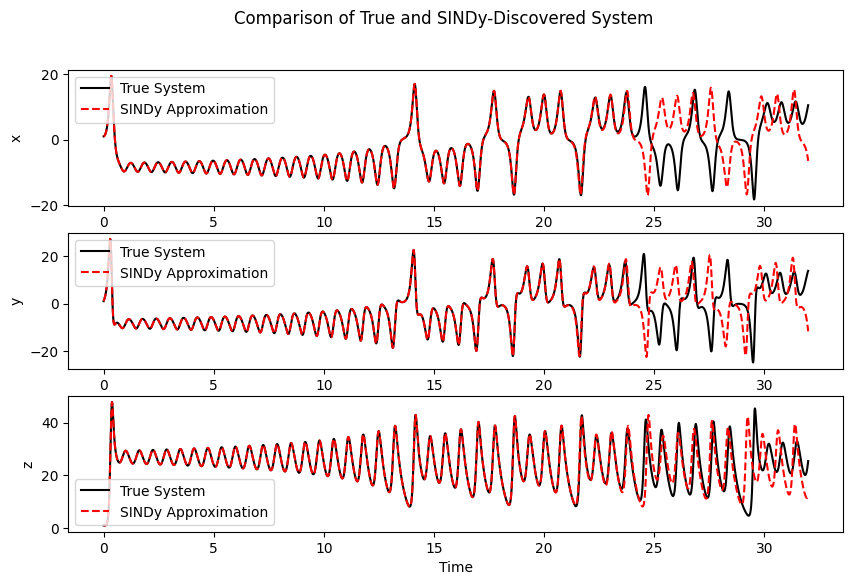

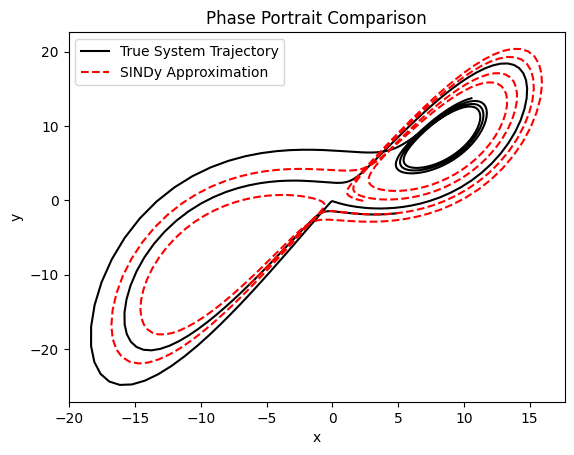

In [12]:
# Plot original vs recovered trajectories
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

labels = ['x', 'y', 'z']
for i in range(3):
    axs[i].plot(t, X[:, i], 'k', label='True System')
    axs[i].plot(t, X_sindy[:, i], '--r', label='SINDy Approximation')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

axs[-1].set_xlabel('Time')
plt.suptitle('Comparison of True and SINDy-Discovered System')
plt.show()


plt.Figure(figsize=(10, 6))
plt.plot(X[-500:, 0], X[-500:, 1], 'k', label='True System Trajectory')
plt.plot(X_sindy[-500:, 0], X_sindy[-500:, 1], '--r', label='SINDy Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait Comparison')
plt.legend()
plt.show()
